In [102]:
import os
import cv2
import numpy as np 
import glob
import random
from random import randrange
from random import randint
import re
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa


def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def generate_position(rgb,mask,scene):
    center_scene = (random_scene.shape[1]//2,random_scene.shape[0]//2)
    center_object = (object_rgb.shape[1]//2,object_rgb.shape[0]//2)
    min_x = center_object[1]
    max_x = random_scene.shape[1]-center_object[0]
    min_y = center_object[0]
    max_y = random_scene.shape[0]-center_object[1]    
    pos_x_generated = randint(min_x, max_x)
    pos_y_generated = randint(min_y, max_y)
    return (pos_x_generated,pos_y_generated)

def prepare_object_data(all_object_names):
    data = {}
    for objects in all_object_names:
        data[objects] = {}
        paths_rgb = glob.glob("../data/Objects/" + str(objects) + "/*/extracted/*png")
        paths_rgb =  natural_sort(paths_rgb)
        paths_mask = glob.glob("../data/Objects/" + str(objects) + "/*/mask/*png")
        paths_mask =  natural_sort(paths_mask)
        data[objects]['rgb'] = paths_rgb
        data[objects]['mask'] = paths_mask
    return data

def get_random_object_name(all_object_names):
    object_name = random.choice(all_object_names)
    return object_name

def get_random_background(all_background_images):
    random_path_scene = random.choice(all_background_images)
    random_scene = cv2.imread(random_path_scene)
    return random_scene

def get_random_image(dict_data,object_name):
    random_index = randrange(len(dict_data[object_name]['rgb']))
    random_path_object = dict_data[object_name]['rgb'][random_index]
    random_path_mask = dict_data[object_name]['mask'][random_index]
    random_object = cv2.imread(random_path_object)
    random_mask = cv2.imread(random_path_mask)
    return (random_object,random_mask)

In [103]:
def get_transformator():
    aug = iaa.Affine(rotate=(-180, 180)) # rotate -15 to 15 deg
    aug = aug.to_deterministic()
    return aug

In [104]:
all_background_path = glob.glob("../data/Background_images/COCO/*")
all_object_names_path = glob.glob("../data/Objects/*")
all_object_names = []
for objects in all_object_names_path:
    all_object_names.append(os.path.basename(objects))


OBJECT_DATA = prepare_object_data(all_object_names)

In [105]:
# Chose random scene
random_scene = get_random_background(all_background_path)
# Chose random object and mask
object_name = get_random_object_name(all_object_names)
(random_object,random_mask) = get_random_image(OBJECT_DATA,"tasse")

In [106]:
aug = get_transformator()

In [107]:
def init_position_matrix(scene_shape):
    occupation_matix = np.zeros((scene_shape[0],scene_shape[1]))
    return occupation_matix


def generate_position(rgb,mask,scene,occupation_matix):
    #Prevent border cropping
    center_scene = (scene.shape[0]//2,scene.shape[1]//2)
    center_object = (rgb.shape[0]//2,rgb.shape[1]//2)
    min_x = center_object[0]
    max_x = scene.shape[0]-center_object[0]
    min_y = center_object[1]
    max_y = scene.shape[1]-center_object[1]  
    occupation_matix = occupation_matix[min_y:max_y,min_x:max_x]
    
    new_occupation_matix=cv2.copyMakeBorder(occupation_matix,
                              top=min_y,
                              bottom=min_y,
                              left=min_x,
                              right=min_x,
                              borderType= cv2.BORDER_CONSTANT,
                              value=[1] )
    
    
    indices = np.where(new_occupation_matix == [0])
    coordinates = list(zip(indices[1], indices[0]))
    random_pos = random.choice(coordinates)
    (pos_x_generated,pos_y_generated) = random_pos
    
    #fig, ax = plt.subplots()
    #plt.imshow(new_occupation_matix)
    #circle = plt.Circle(random_pos, 4, color='r')
    #ax.add_patch(circle)
    
    return (pos_x_generated,pos_y_generated)

In [121]:
def alpha_cloning(background,foreground,alpha,position):
    

    #print("background.shape : ")
    #print(background.shape)    

    top    =  position[0] - foreground.shape[0]//2
    bottom =  background.shape[0] - top - foreground.shape[0]
    
    left   =  position[1] - foreground.shape[1]//2
    right  =  background.shape[1] - left - foreground.shape[1]
    

    print("====")
    print(top)
    print(bottom)
    print(left)
    print(right)
    print(top)
    print("====")
    
    foreground=cv2.copyMakeBorder(foreground,
                              top=top,
                              bottom=bottom,
                              left=left,
                              right=right,
                              borderType= cv2.BORDER_CONSTANT,
                              value=[0] )
    #print("foreground.shape : ")
    #print(foreground.shape)
    alpha=cv2.copyMakeBorder(alpha,
                              top=top,
                              bottom=bottom,
                              left=left,
                              right=right,
                              borderType= cv2.BORDER_CONSTANT,
                              value=[0] )

    # Convert uint8 to float
    foreground = foreground.astype(float)
    cv2.imwrite("foreground.png", foreground);
    background = background.astype(float)
    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255
    #print("alpha.shape : ")
    #print(alpha.shape)
    #cv2.imwrite("alpha.png", alpha);
    #print(foreground.shape)
    #print(alpha.shape)
    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)
    #print("new foreground.shape : ")
    #print(foreground.shape)
    
    
    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)
    #print("new background.shape : ")
    #print(background.shape) 
    # Add the masked foreground and background.
    outImage = cv2.add(foreground, background)
    #print("new outImage.shape : ")
    #print(outImage.shape) 
    
    return outImage

====
3
199
235
180
3
====
====
119
83
65
350
119
====


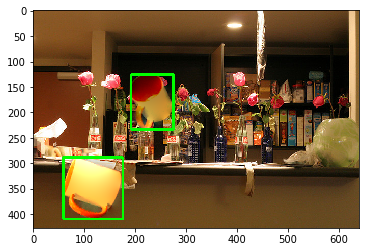

In [122]:
###
# Multi-object image generator

NB_OBJECT_MAX = 3
NB_OBJECT_MIN = 1

nb_object = randrange(NB_OBJECT_MIN,NB_OBJECT_MAX+1)
occupation_matix = init_position_matrix(random_scene.shape)
# Chose random scene
random_scene = get_random_background(all_background_path)

for i in range(nb_object):

    # Chose random object and mask
    object_name = get_random_object_name(all_object_names)
    (random_object,random_mask) = get_random_image(OBJECT_DATA,"tasse")
    #Create the image transformer
    aug = get_transformator()
    #Transform both the mask and image with the same trasformation
    object_rgb = aug.augment_images([random_object])[0]
    object_mask = aug.augment_images([random_mask])[0]

    # Dilate mask
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(object_mask,kernel,iterations = 2)

    #Generate the random position
    position = generate_position(object_rgb,object_mask,random_scene,occupation_matix)
    #print(position)
    # Clone seamlessly.
    output = cv2.seamlessClone(object_rgb, random_scene, dilation, position, cv2.NORMAL_CLONE)

    # Draw bounding box
    object_mask = cv2.cvtColor(object_mask, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(object_mask,127,255,0)
    _,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = max(contours, key = cv2.contourArea)
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    x,y,w,h = cv2.boundingRect(cnt)
    x += (position[0] - cx)
    y += (position[1] - cy)
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),4)
    occupation_matix = alpha_cloning(occupation_matix,object_mask,object_mask,position)
    random_scene = output
    
    
cv2.imwrite("image.png", output);
plt.imshow(output[:,:,::-1])   
    


In [110]:
cv2.imwrite("outImg.png", outImage)
cv2.imwrite("outMask.png", outMask)

True

In [101]:
foreground.shape[0]

225